In [1]:
%load_ext autoreload
%autoreload 2
import queue
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import sys
sys.path.append('./')
from simulator import simulator
from tqdm import tqdm
random.seed(10)

# Traffic Curve Lookup Table

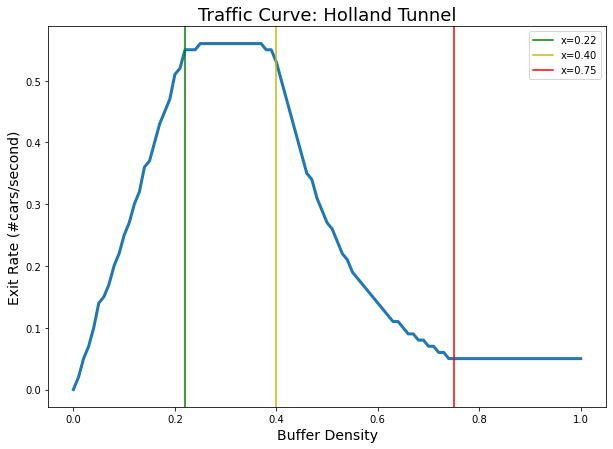

In [2]:
speed_lim = []
for i in range(0,22):
    b = i/100
    s = 9.9
    c = (b*s)/4
    speed_lim.append([b,c,s])

lookup = []
for i in range(54,100):
    s = i/10
    b = 4.0/(4.0+0.675*s+0.076*(s**2))
    c = s/(4.0+0.675*s+0.076*(s**2))
    lookup.append([b,c,s])
lookup = lookup[::-1]

lookup = speed_lim + lookup

for i in range(41,76):
    b = i/100
    c = 0.54*math.exp(-(b-0.40)*6.799)
    s = (4*c)/b
    lookup.append([b,c,s])

for i in range(76,101):
    b = i/100
    c = 0.05
    s = 0.27
    lookup.append([b,c,s])

lookup = np.array(lookup)

curve = []
for i in range(0,101):
    l = i/100
    row = lookup[(lookup[:,0]>=l) & (lookup[:,0]<l+0.01)].mean(axis=0).tolist()
    row[0] = l
    row[1] = round(row[1],2)
    row[2] = round(row[2],2)
    curve.append(row)

curve = np.array(curve)

plt.figure(figsize=(10,7))
plt.xlabel('Buffer Density',size=14)
plt.ylabel('Exit Rate (#cars/second)',size=14)
plt.title('Traffic Curve: Holland Tunnel',size=18)
plt.plot(curve[:,0],curve[:,1],lw=3)
plt.axvline(0.22,c='g',label='x=0.22')
plt.axvline(0.40,c='y', label='x=0.40')
plt.axvline(0.75,c='r', label='x=0.75')
plt.legend()

# Simulator

In [3]:
# class simulator:
#     def __init__(self, edges, lengths, input_edges, next_edge, curve, merges):
#         self.edges = edges
#         self.lengths = lengths
#         self.input_edges = input_edges
#         self.next_edge = next_edge
#         self.curve = curve
#         self.merges = merges
#         self.time = 0
#         self.throughput = []
#         self.buffers = {}
#         self.edge_inputs = {}
#         self.edge_outputs = {}
#         self.eligible = {}
#         for edge in self.edges:
#             self.buffers[edge] = queue.Queue(int(self.lengths[edge]/4))
#             self.edge_inputs[edge] = 0
#             self.edge_outputs[edge] = 0
#             self.eligible[edge] = 0
    
#     def iteration_nosignal(self,input_rate):
#         self.time = self.time + 1
#         for edge in self.edges:
#             for i in range(self.buffers[edge].qsize()):
#                 if(self.buffers[edge].qsize()):
#                     if(self.buffers[edge].queue[i][1]>self.time):
#                         self.eligible[edge] = i
#                         break
#             b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#             if(self.eligible[edge]):
#                 self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                 if(self.edge_outputs[edge]>=1):
#                     _ = self.buffers[edge].get()
#                     self.edge_outputs[edge] -= 1
#                     next_edge = random.choice(self.next_edge[edge])
#                     if(next_edge is not None):
#                         b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                         self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                    timeout=0.1)
#                     else:
#                         self.throughput.append(self.time)
#             if edge in self.input_edges:
#                 self.edge_inputs[edge] += input_rate[edge]
#                 if(self.edge_inputs[edge]>=1):
#                     self.buffers[edge].put((self.time,self.time+(self.lengths[edge]/self.curve[self.curve[:,0]==b][0][2])), timeout=0.1)
#                     self.edge_inputs[edge] -= 1    
    
#     def iter_merge_equisignal(self,in_edges,out_edge):
#         schedule = {i:in_edges[i] for i in range(len(in_edges))}
#         for edge in in_edges+[out_edge]:
#             b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#             scheduled_edge = schedule[(self.time//10)%len(in_edges)]
#             if(self.eligible[edge]):
#                 if(edge in in_edges):
#                     if(edge==scheduled_edge):
#                         self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                         if(self.edge_outputs[edge]>=1):
#                             _ = self.buffers[edge].get()
#                             self.edge_outputs[edge] -= 1
#                             b_out = self.buffers[out_edge].qsize()/(self.lengths[out_edge]/4)
#                             self.buffers[out_edge].put((self.time,self.time+(self.lengths[out_edge]/self.curve[self.curve[:,0]==b_out][0][2])),\
#                                                        timeout=0.1)
#                 else:
                    
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         next_edge = random.choice(self.next_edge[edge])
#                         if(next_edge is not None):
#                             b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                             self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                        timeout=0.1)
#                         else:
#                             self.throughput.append(self.time)
    
#     def iteration_equisignal(self,input_rate):
#         self.time = self.time + 1
#         for edge in self.edges:
#             for i in range(self.buffers[edge].qsize()):
#                 if(self.buffers[edge].qsize()):
#                     if(self.buffers[edge].queue[i][1]>self.time):
#                         self.eligible[edge] = i
#                         break
#             b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#             if edge in self.input_edges:
#                 self.edge_inputs[edge] += input_rate[edge]
#                 if(self.edge_inputs[edge]>=1):
#                     self.buffers[edge].put((self.time,self.time+(self.lengths[edge]/self.curve[self.curve[:,0]==b][0][2])), timeout=0.1)
#                     self.edge_inputs[edge] -= 1
                    
#         all_edges = set(self.edges)
#         union_merge = set()
#         for merge in self.merges:
#             in_edges, out_edge = merge[0], merge[1]
#             self.iter_merge_equisignal(in_edges,out_edge)
#             union_merge = union_merge.union(set(in_edges))
#             union_merge = union_merge.union({out_edge})
#         rem_edges = all_edges - union_merge
#         if(len(rem_edges)):
#             for edge in rem_edges:
#                 b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#                 if(self.eligible[edge]):
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         next_edge = random.choice(self.next_edge[edge])
#                         if(next_edge is not None):
#                             b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                             self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                        timeout=0.1)
#                         else:
#                             self.throughput.append(self.time)
                    
#     def iter_merge_self_regulate(self,in_edges,out_edge):
#         for edge in in_edges+[out_edge]:
#             if(edge not in in_edges):
#                 b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#                 if(self.eligible[edge]):
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         self.throughput.append(self.time)
#             else:
#                 if(self.eligible[edge]):
#                     b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#                     alpha = self.get_alpha(in_edges,out_edge)
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]*min(1,alpha)
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         next_edge = random.choice(self.next_edge[edge])
#                         b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                         self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                    timeout=0.1)
    
    
#     def iteration_self_regulate(self,input_rate):
#         self.time += 1
#         for edge in self.edges:
#             for i in range(self.buffers[edge].qsize()):
#                 if(self.buffers[edge].qsize()):
#                     if(self.buffers[edge].queue[i][1]>self.time):
#                         self.eligible[edge] = i
#                         break
#             b = self.buffers[edge].qsize()/(self.lengths[edge]/4)                             
#             if edge in self.input_edges:
#                     self.edge_inputs[edge] += input_rate[edge]
#                     if(self.edge_inputs[edge]>=1):
#                         self.buffers[edge].put((self.time,self.time+(self.lengths[edge]/self.curve[self.curve[:,0]==b][0][2])), timeout=0.1)
#                         self.edge_inputs[edge] -= 1    
                        
#         all_edges = set(self.edges)
#         union_merge = set()
#         for merge in self.merges:
#             in_edges, out_edge = merge[0], merge[1]
#             self.iter_merge_self_regulate(in_edges,out_edge)
#             union_merge.union(set(in_edges))
#             union_merge.union({out_edge})
#         rem_edges = all_edges - union_merge
#         if(rem_edges is not None):
#             for edge in rem_edges:
#                 b = self.buffers[edge].qsize()/(self.lengths[edge]/4)
#                 if(self.eligible[edge]):
#                     self.edge_outputs[edge] += self.curve[self.curve[:,0]==b][0][1]
#                     if(self.edge_outputs[edge]>=1):
#                         _ = self.buffers[edge].get()
#                         self.edge_outputs[edge] -= 1
#                         next_edge = random.choice(self.next_edge[edge])
#                         if(next_edge is not None):
#                             b_next = self.buffers[next_edge].qsize()/(self.lengths[next_edge]/4)
#                             self.buffers[next_edge].put((self.time,self.time+(self.lengths[next_edge]/self.curve[self.curve[:,0]==b_next][0][2])),\
#                                                        timeout=0.1)
#                         else:
#                             self.throughput.append(self.time)
            
              
#     def get_throughput(self):
#         return(self.throughput)
    
#     def get_alpha(self,in_edges,out_edge):
#         b_lim = 0.33
#         c_lim = self.curve[self.curve[:,0]==b_lim][0][1]
#         b_out = self.buffers[out_edge].qsize()/(self.lengths[out_edge]/4)
#         b_ratio = {}
#         for edge in in_edges:
#             b_ratio[edge] = (self.buffers[edge].qsize()/(self.lengths[edge]/4))
#         factor = 1/sum(b_ratio.values())
#         c_norm = {}
#         for edge in in_edges:
#             b_ratio[edge] = b_ratio[edge]*factor
#             b = (self.buffers[edge].qsize()/(self.lengths[edge]/4))
#             c = self.curve[self.curve[:,0]==b][0][1]
#             c_norm[edge] = c*b_ratio[edge]
        
#         if(sum(b_ratio.values())):
#             if(b_lim-b_out>0):
#                 alpha = (b_lim-b_out+c_lim)/(sum(c_norm.values()))
#             else:
#                 alpha=0
#         else:
#             alpha = 1        
#         return(alpha)
    

# Experiments on Holland Tunnel

## Holland Tunnel Manhattan to NJ

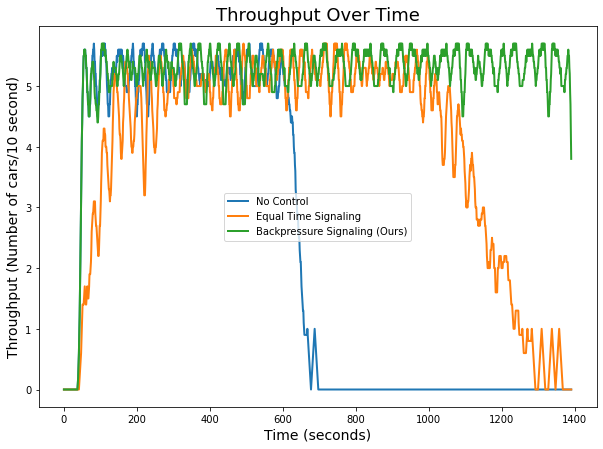

In [134]:
top_G = {'A':['E'],'B':['E'],'C':['E'],'D':['E'],'E':['F']}
edges = []
for key,val in top_G.items():
    for node in val:
        edges.append(key+node)

lengths = {'AE':200,'BE':200,'CE':200,'DE':200,'EF':200}

input_edges = ['AE', 'BE', 'CE', 'DE']

next_edge = {'AE':['EF'], 'BE':['EF'], 'CE':['EF'], 'DE':['EF'], 'EF':[None]}

merges = [[['AE', 'BE', 'CE', 'DE'], 'EF']]

base_input_rate = {'AE':0.132, 'BE':0.132, 'CE':0.132, 'DE':0.132}
v = 0.145
burst_input_rate = {'AE':v, 'BE':v, 'CE':v, 'DE':v}

i1, i2, i3 = 500, 400, 500

S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_equisignal(base_input_rate)
    for k in range(i2):
        S.iteration_equisignal(burst_input_rate)
    for k in range(i3):
        S.iteration_equisignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_equisignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_equisignalling = np.convolve(throughput_equisignalling, kernel, mode='valid')

S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_self_regulate(base_input_rate)
    for k in range(i2):
        S.iteration_self_regulate(burst_input_rate)
    for k in range(i3):
        S.iteration_self_regulate(base_input_rate)
except:
    pass
time_arr = np.array(S.get_throughput())
throughput_self_regulate = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_self_regulate = np.convolve(throughput_self_regulate, kernel, mode='valid')

S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_nosignal(base_input_rate)
    for k in range(i2):
        S.iteration_nosignal(burst_input_rate)
    for k in range(i3):
        S.iteration_nosignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_nosignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_nosignalling = np.convolve(throughput_nosignalling, kernel, mode='valid')

time_axis = [i for i in range(0,len(throughput_self_regulate))]

plt.figure(figsize=(10,7))
plt.plot(time_axis,throughput_nosignalling, label='No Control', lw=2)
plt.plot(time_axis,throughput_equisignalling, label='Equal Time Signaling', lw=2)
plt.plot(time_axis,throughput_self_regulate, label='Backpressure Signaling (Ours)', lw=2)
plt.ylabel('Throughput (Number of cars/10 second)',size=14)
plt.xlabel('Time (seconds)',size=14)
plt.title('Throughput Over Time',size=18)
plt.legend()

# Holland Tunnel NJ to M

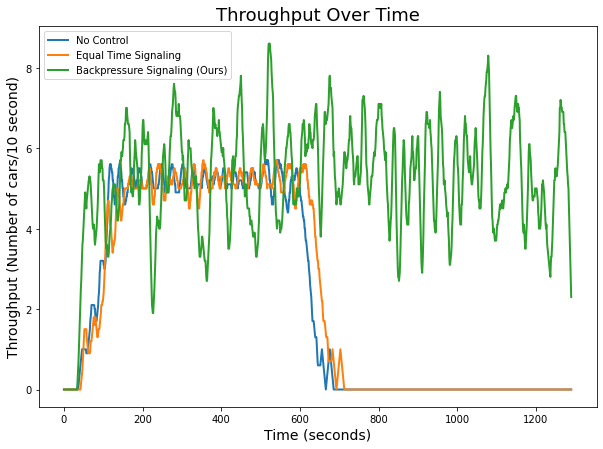

In [135]:
top_G = {'A':['D'],'B':['D'],'C':['D'],'D':['F'],'E':['F'], 'F':['H'], 'G':['H'], 'H':['J'], 'I':['J'], 'J':['K']}
edges = []
for key,val in top_G.items():
    for node in val:
        edges.append(key+node)

lengths = {i:200 for i in edges}

input_edges = ['AD', 'BD', 'CD', 'EF', 'GH', 'IJ']
for edge in input_edges:
    lengths[edge] = 100

next_edge = {'AD':['DF'], 'BD':['DF'], 'CD':['DF'], 'DF':['FH'], 'EF':['FH'], 'FH':['HJ'], 'GH':['HJ'], 'HJ':['JK'], 'IJ':['JK'], 'JK':[None]}

merges = [[['AD', 'BD', 'CD'], 'DF'],[['DF','EF'],'FH'],[['FH','GH'],'HJ'],[['HJ','IJ'],'JK']]

base_input_rate = {'AD':0.088, 'BD':0.088, 'CD':0.088, 'EF':0.088, 'GH':0.088, 'IJ':0.088}
v=0.097
burst_input_rate = {'AD':v, 'BD':v, 'CD':v, 'EF':v, 'GH':v, 'IJ':v}

i1, i2, i3 = 500, 300, 500

S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_equisignal(base_input_rate)
    for k in range(i2):
        S.iteration_equisignal(burst_input_rate)
    for k in range(i3):
        S.iteration_equisignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_equisignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_equisignalling = np.convolve(throughput_equisignalling, kernel, mode='valid')

S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_self_regulate(base_input_rate)
    for k in range(i2):
        S.iteration_self_regulate(burst_input_rate)
    for k in range(i3):
        S.iteration_self_regulate(base_input_rate)
except:
    pass
time_arr = np.array(S.get_throughput())
throughput_self_regulate = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_self_regulate = np.convolve(throughput_self_regulate, kernel, mode='valid')

S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_nosignal(base_input_rate)
    for k in range(i2):
        S.iteration_nosignal(burst_input_rate)
    for k in range(i3):
        S.iteration_nosignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_nosignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_nosignalling = np.convolve(throughput_nosignalling, kernel, mode='valid')

time_axis = [i for i in range(0,len(throughput_self_regulate))]

plt.figure(figsize=(10,7))
plt.plot(time_axis,throughput_nosignalling, label='No Control', lw=2)
plt.plot(time_axis,throughput_equisignalling, label='Equal Time Signaling', lw=2)
plt.plot(time_axis,throughput_self_regulate, label='Backpressure Signaling (Ours)', lw=2)
plt.ylabel('Throughput (Number of cars/10 second)',size=14)
plt.xlabel('Time (seconds)',size=14)
plt.title('Throughput Over Time',size=18)
plt.legend()

# Nairobi Intersection

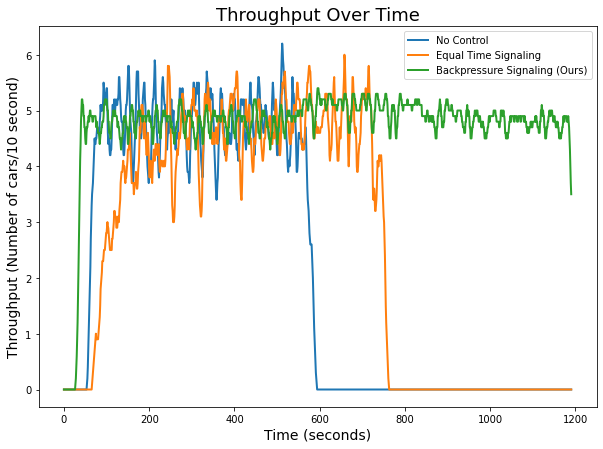

In [137]:
top_G = {'A':['E'],'B':['E'],'C':['E'],'D':['E'],'E':['F'], 'F':['G','H','I','J']}
edges = []
for key,val in top_G.items():
    for node in val:
        edges.append(key+node)

lengths = {i:200 for i in edges}

input_edges = ['AE', 'BE', 'CE', 'DE']
lengths['EF'] = 80

next_edge = {'AE':['EF'], 'BE':['EF'], 'CE':['EF'], 'DE':['EF'], 'EF':['FG','FH','FI','FJ'], 'FG':[None], 'FH':[None],\
             'FI':[None], 'FJ':[None]}

merges = [[['AE', 'BE', 'CE', 'DE'], 'EF']]

base_input_rate = {'AE':0.120, 'BE':0.120, 'CE':0.120, 'DE':0.120}
v = 0.132
burst_input_rate = {'AE':v, 'BE':v, 'CE':v, 'DE':v}

i1, i2, i3 = 500, 200, 500

S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_equisignal(base_input_rate)
    for k in range(i2):
        S.iteration_equisignal(burst_input_rate)
    for k in range(i3):
        S.iteration_equisignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_equisignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_equisignalling = np.convolve(throughput_equisignalling, kernel, mode='valid')

S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_self_regulate(base_input_rate)
    for k in range(i2):
        S.iteration_self_regulate(burst_input_rate)
    for k in range(i3):
        S.iteration_self_regulate(base_input_rate)
except:
    pass
time_arr = np.array(S.get_throughput())
throughput_self_regulate = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_self_regulate = np.convolve(throughput_self_regulate, kernel, mode='valid')

S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
try:
    for k in range(i1):
        S.iteration_nosignal(base_input_rate)
    for k in range(i2):
        S.iteration_nosignal(burst_input_rate)
    for k in range(i3):
        S.iteration_nosignal(base_input_rate)
except:
    pass

time_arr = np.array(S.get_throughput())
throughput_nosignalling = np.array([len(time_arr[(time_arr>=i) & (time_arr<i+10)]) for i in range(0,i1+i2+i3,1)])
kernel_size = 10
kernel = np.ones(kernel_size) / kernel_size
throughput_nosignalling = np.convolve(throughput_nosignalling, kernel, mode='valid')

time_axis = [i for i in range(0,len(throughput_self_regulate))]

plt.figure(figsize=(10,7))
plt.plot(time_axis,throughput_nosignalling, label='No Control', lw=2)
plt.plot(time_axis,throughput_equisignalling, label='Equal Time Signaling', lw=2)
plt.plot(time_axis,throughput_self_regulate, label='Backpressure Signaling (Ours)', lw=2)
plt.ylabel('Throughput (Number of cars/10 second)',size=14)
plt.xlabel('Time (seconds)',size=14)
plt.title('Throughput Over Time',size=18)
plt.legend()

# Non Uniform Traffic Flow

In [4]:
burst_val = 0.132
i1, i2, i3 = 500, 0, 500
perf = {}
for i in tqdm(range(25)):
    eps = ((i+1)/25)*burst_val
    hits_eq, hits_no, hits_bp = 0, 0, 0
    for trials in range(20):
        random_input_rates = []
        for i in range(len(input_edges)):
            random_input_rates.append(random.uniform(burst_val-eps,burst_val+eps))
        norm = (burst_val*len(input_edges))/sum(random_input_rates)
        
        random_input_rates = [random_input_rates[i]*norm for i in range(len(random_input_rates))]
        base_input_rate = {input_edges[i]:random_input_rates[i] for i in range(len(input_edges))}

        S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
        try:
            for k in range(i1):
                S.iteration_equisignal(base_input_rate)
            # for k in range(i2):
            #     S.iteration_equisignal(burst_input_rate)
            for k in range(i3):
                S.iteration_equisignal(base_input_rate)
        except:
            pass
    
        if(S.time==1000):
            hits_eq+=1
            
        S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
        try:
            for k in range(i1):
                S.iteration_nosignal(base_input_rate)
            # for k in range(i2):
            #     S.iteration_nosignal(burst_input_rate)
            for k in range(i3):
                S.iteration_nosignal(base_input_rate)
        except:
            pass
        
    
        if(S.time==1000):
            hits_no+=1
            
        S = simulator(edges, lengths, input_edges, next_edge, curve, merges)
        try:
            for k in range(i1):
                S.iteration_self_regulate(base_input_rate)
            # for k in range(i2):
            #     S.iteration_self_regulate(burst_input_rate)
            for k in range(i3):
                S.iteration_self_regulate(base_input_rate)
        except:
            pass
    
        
        if(S.time==1000):
            hits_bp+=1
            
    #     break
    # break
            
    score_eq = hits_eq/20
    score_no = hits_no/20
    score_bp = hits_bp/20
    perf[eps] = [score_no,score_eq,score_bp]

100%|██████████| 25/25 [02:56<00:00,  7.08s/it]


In [5]:
perf

{0.00528: [0.0, 1.0, 1.0],
 0.01056: [0.0, 1.0, 1.0],
 0.01584: [0.0, 1.0, 1.0],
 0.02112: [0.0, 1.0, 1.0],
 0.026400000000000003: [0.0, 1.0, 1.0],
 0.03168: [0.0, 1.0, 1.0],
 0.03696000000000001: [0.0, 1.0, 1.0],
 0.04224: [0.0, 1.0, 1.0],
 0.04752: [0.0, 1.0, 1.0],
 0.05280000000000001: [0.0, 1.0, 1.0],
 0.05808: [0.0, 1.0, 1.0],
 0.06336: [0.0, 1.0, 1.0],
 0.06864: [0.0, 1.0, 1.0],
 0.07392000000000001: [0.0, 1.0, 1.0],
 0.0792: [0.0, 1.0, 1.0],
 0.08448: [0.0, 1.0, 1.0],
 0.08976: [0.0, 1.0, 1.0],
 0.09504: [0.0, 1.0, 1.0],
 0.10032: [0.0, 1.0, 1.0],
 0.10560000000000001: [0.0, 1.0, 1.0],
 0.11088: [0.0, 1.0, 1.0],
 0.11616: [0.0, 1.0, 1.0],
 0.12144: [0.0, 1.0, 1.0],
 0.12672: [0.0, 1.0, 1.0],
 0.132: [0.0, 1.0, 1.0]}

In [17]:
(904//900)%4

1

In [29]:
q = queue.Queue()

In [30]:
q.put(1)

In [31]:
q.put(1)

In [32]:
q.queue

deque([1, 1])